In [5]:
#import packages
import networkx as nx
import json
from networkx.readwrite import json_graph

#load data
file_path = '/Users/brookefeinberg/SamplingBalancedForests/cnty_or.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    oregon = json_graph.adjacency_graph(data)


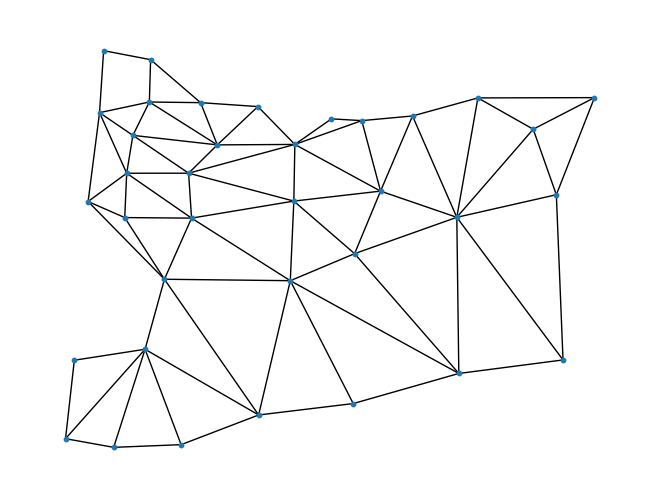

In [8]:
#plot of oregon
import matplotlib.pyplot as plt
node_locations = { v : ( float(oregon.nodes()[v]["INTPTLON20"]), float(oregon.nodes()[v]["INTPTLAT20"])) for v in oregon.nodes() }
plt.figure()
nx.draw(oregon, node_size = 10, pos = node_locations)
plt.show()

In [262]:
#Wilson's Algorithm

import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

class WilsonsAlgorithm:
    def __init__(self, graph):
        self.graph = graph  #store networkX graph 
        self.adj_list = {v: list(graph.neighbors(v)) for v in graph.nodes()}  #for each graph node return the neighbors and store it as a dictionary where node is the key and each value corresponds to a list of its neighbors 
        self.InTree = {node: False for node in self.adj_list}  #initalizes dictionary to keep track of whether nodes have been included in the spanning tree -- FALSE as initial value menaing node has yet to be included in the tree 
        self.Next = {node: None for node in self.adj_list}  #initalizes dictionary to track path each node takes in a random walk 
    
    def random_edge(self, v): #randomly selects an edge for a given node v 
        return random.choice(self.adj_list[v]) #retrieves the list of neighbors for node v in the adjacency list and randomly picks one -- simulating step ina  random walk 

    def RandomTreeWithRoot(self, r): #generate random spanning tree with r as the root node 
        self.InTree = {node: False for node in self.adj_list} #initalize all nodes as not in the spanning tree 
        self.InTree[r] = True  #mark root node as in the tree 
        self.Next[r] = -1  #root node has no parent aka no incoming edges 

        for node in self.adj_list: #loops through each nodein the graph, attempting to find a path to the root using a random walk 
            path = []  
            while not self.InTree[node]: #loop continues as long as node is not already in the spanning tree 
                path.append(node)  #record each step of the random walk 
                self.Next[node] = self.random_edge(node) #choose a random neighbor & record it as the next step in the walk (connects node to its next random neighbor in the path)
                node = self.Next[node]  #update next node and the new node so the loop continues till we reach a node already in the spanning tree 
            for vertex in path:  #loop has broken bc we've reached a node already part of the spanning tree 
                self.InTree[vertex] = True  #adds each vertex to the spanning tree from the root outward 

    def sample(self, seed=None):
        if seed is not None: #can include seed later on for reproducible results 
            random.seed(seed)
        root = random.choice(list(self.adj_list.keys()))  #picks a random node to be a root 
        self.RandomTreeWithRoot(root) #builds ranodm spannign tree with the ranodm root chosen 

        spanning_tree = []  #extract edges of spannign tree for plotting 
        for node in self.adj_list: 
            if self.Next[node] != -1 and self.Next[node] is not None: #find nodes connected to another node in the tree 
                spanning_tree.append((node, self.Next[node])) #addes connection or edge as a tuple of two nodes to the spanning tree list 
        return spanning_tree, root #returns all the edges in the form of (node1, node2) and the root node 

    def draw_tree(self, spanning_tree, root, node_locations): #plot the spanning tree on the graph
        plt.figure(figsize=(8, 8))
        nx.draw(self.graph, pos=node_locations, node_size=10, edge_color='lightgray') #draw original graph 
        nx.draw_networkx_edges(self.graph, pos=node_locations, edgelist=spanning_tree, edge_color='red', width=2) #draw spanning tree 
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=[root], node_color='yellow', node_size=50)  #draw root node 
        plt.show()

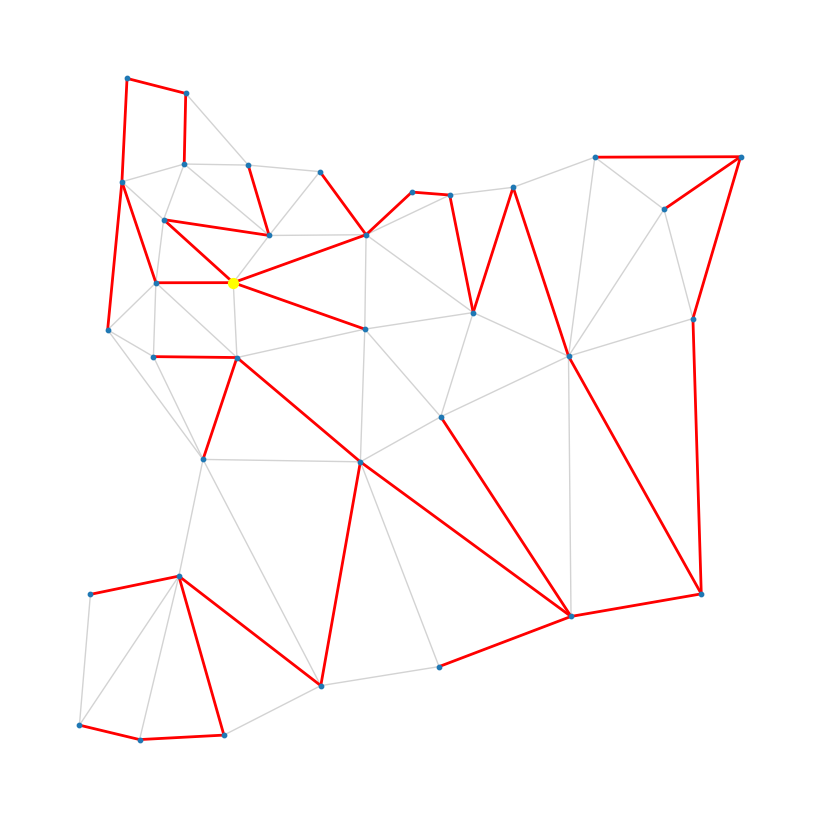

In [287]:
#plot of oregon's spannig tree 
 
node_locations = {v: (float(oregon.nodes[v]["INTPTLON20"]), float(oregon.nodes[v]["INTPTLAT20"])) for v in oregon.nodes()}
wilson = WilsonsAlgorithm(oregon)
spanning_tree, root = wilson.sample()
wilson.draw_tree(spanning_tree, root, node_locations)

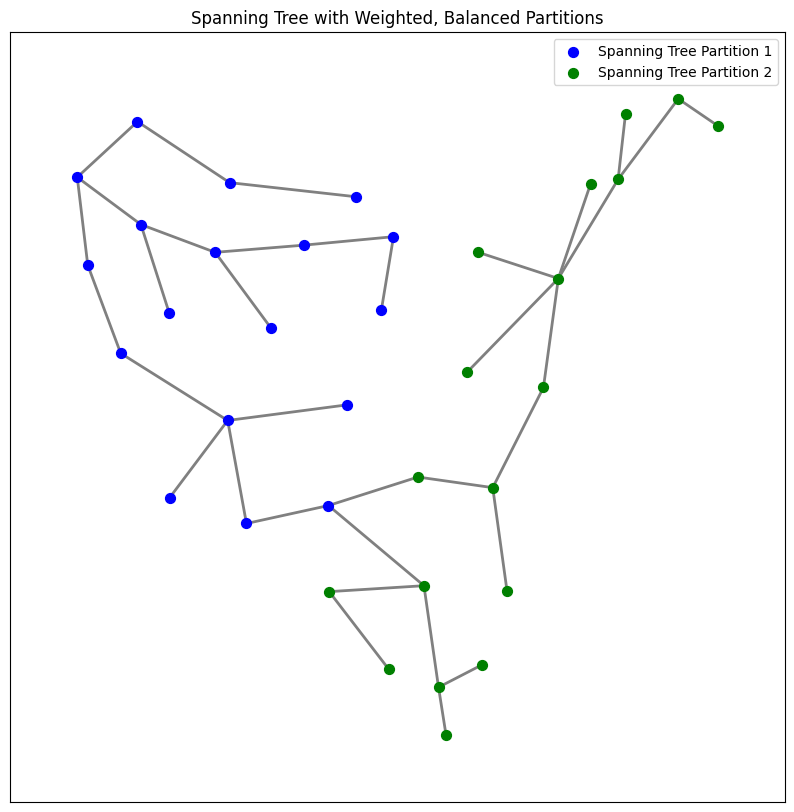

In [286]:
class GraphPartitioner:
    def __init__(self, graph, k):
        self.graph = graph
        self.k = k

    def create_weighted_partitions_and_draw_spanning_tree(self):
        # Generate a random spanning tree using Wilson's Algorithm
        wilson = WilsonsAlgorithm(self.graph)
        spanning_tree, root = wilson.sample()

        # Create a new graph object with the spanning tree edges
        tree_graph = nx.Graph()
        tree_graph.add_edges_from(spanning_tree)

        # Split the tree using BFS into k balanced partitions
        partitions = [[] for _ in range(self.k)]
        partition_sizes = [0] * self.k
        queue = deque([root])
        current_partition = 0
        
        while queue:
            node = queue.popleft()
            partitions[current_partition].append(node)
            partition_sizes[current_partition] += 1
            if partition_sizes[current_partition] >= len(tree_graph) // self.k:
                current_partition = (current_partition + 1) % self.k
            for neighbor in tree_graph.neighbors(node):
                if all(neighbor not in part for part in partitions):
                    queue.append(neighbor)

        # Visualize the spanning tree partitions
        pos = nx.spring_layout(self.graph)  # Get positions for the nodes for visualization
        plt.figure(figsize=(10, 10))

        # Plot each partition of the spanning tree in a different color
        colors = ['blue', 'green', 'purple', 'orange', 'pink', 'cyan']
        for i, partition in enumerate(partitions):
            nx.draw_networkx_nodes(tree_graph, pos, nodelist=partition, node_size=50, 
                                   node_color=colors[i % len(colors)], label=f'Spanning Tree Partition {i+1}')
        
        # Draw edges of the spanning tree in dark gray
        nx.draw_networkx_edges(tree_graph, pos, edge_color='gray', width=2)
        
        plt.legend()
        plt.title("Spanning Tree with Weighted, Balanced Partitions")
        plt.show()

# Usage example:
G = oregon  # Example random graph
k = 2  # Number of partitions
partitioner = GraphPartitioner(G, k)
partitioner.create_weighted_partitions_and_draw_spanning_tree()

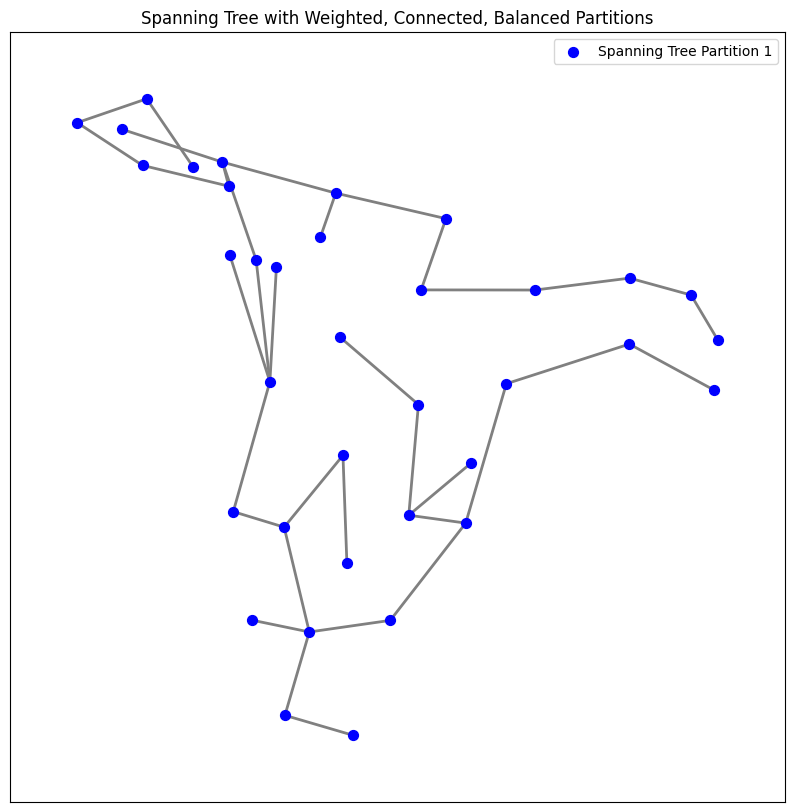

In [249]:
class GraphPartitioner:
    def __init__(self, graph, k):
        self.graph = graph
        self.k = k

    def create_weighted_partitions_and_draw_spanning_tree(self):
        # Generate a random spanning tree using Wilson's Algorithm
        wilson = WilsonsAlgorithm(self.graph)
        spanning_tree, root = wilson.sample()

        # Create a new graph object with the spanning tree edges
        tree_graph = nx.Graph()
        tree_graph.add_edges_from(spanning_tree)

        # Calculate the ideal partition size and check splittability
        total_nodes = len(tree_graph)
        ideal_size = total_nodes // self.k
        if total_nodes % self.k != 0:
            print("The graph is not splittable into balanced partitions.")
            return

        # Step 1: Initialize BFS queues for each partition to ensure connectivity
        partitions = [[] for _ in range(self.k)]
        partition_sizes = [0] * self.k
        bfs_queues = [deque([root])] + [deque() for _ in range(self.k - 1)]  # Start root in the first partition

        visited = set([root])
        partitions[0].append(root)
        partition_sizes[0] += 1

        # Step 2: BFS to grow partitions while ensuring connectivity and balancing
        for current_partition in range(self.k):
            while partition_sizes[current_partition] < ideal_size and bfs_queues[current_partition]:
                node = bfs_queues[current_partition].popleft()
                for neighbor in tree_graph.neighbors(node):
                    if neighbor not in visited:
                        partitions[current_partition].append(neighbor)
                        partition_sizes[current_partition] += 1
                        visited.add(neighbor)
                        bfs_queues[current_partition].append(neighbor)
                        # Check if partition size limit is reached
                        if partition_sizes[current_partition] >= ideal_size:
                            break

            # Verify if partition has reached ideal size, else return not splittable
            if partition_sizes[current_partition] < ideal_size:
                print("The graph is not splittable into balanced partitions.")
                return

            # Initialize the next partition with an unvisited node if available
            unvisited_nodes = [n for n in tree_graph.nodes if n not in visited]
            if unvisited_nodes and current_partition + 1 < self.k:
                seed_node = unvisited_nodes[0]
                partitions[current_partition + 1].append(seed_node)
                partition_sizes[current_partition + 1] += 1
                visited.add(seed_node)
                bfs_queues[current_partition + 1].append(seed_node)

        # Step 3: Visualize the spanning tree partitions if balanced partitions are achieved
        pos = nx.spring_layout(self.graph)  # Get positions for the nodes for visualization
        plt.figure(figsize=(10, 10))

        # Plot each partition of the spanning tree in a different color
        colors = ['blue', 'green', 'purple', 'orange', 'pink', 'cyan']
        for i, partition in enumerate(partitions):
            nx.draw_networkx_nodes(tree_graph, pos, nodelist=partition, node_size=50, 
                                   node_color=colors[i % len(colors)], label=f'Spanning Tree Partition {i+1}')
        
        # Draw edges of the spanning tree in dark gray
        nx.draw_networkx_edges(tree_graph, pos, edge_color='gray', width=2)
        
        plt.legend()
        plt.title("Spanning Tree with Weighted, Connected, Balanced Partitions")
        plt.show()

# Usage example:
G = oregon  # Example random graph
k = 1  # Number of partitions
partitioner = GraphPartitioner(G, k)
partitioner.create_weighted_partitions_and_draw_spanning_tree()

In [257]:
G = nx.balanced_tree(3, 3)  # Creates a balanced tree with branching factor 3 and height 3 (39 nodes)
k = 3  # Number of partitions
partitioner = GraphPartitioner(G, k)
partitioner.create_weighted_partitions_and_draw_spanning_tree()

The graph is not splittable into balanced partitions.


In [261]:
class SpanningTreePartitioner:
    def __init__(self, graph, k):
        self.graph = graph
        self.k = k

    def partition_spanning_tree(self):
        # Generate a random spanning tree using Wilson's Algorithm
        wilson = WilsonsAlgorithm(self.graph)
        spanning_tree, root = wilson.sample()

        # Create a new graph object with the spanning tree edges
        tree_graph = nx.Graph()
        tree_graph.add_edges_from(spanning_tree)

        # Calculate ideal partition size and ensure splittability
        total_nodes = len(tree_graph)
        ideal_size = total_nodes // self.k
        if total_nodes % self.k != 0:
            print("The spanning tree is not splittable into balanced partitions.")
            return

        # Step 1: Initialize BFS queues for each partition to ensure connectivity
        partitions = [[] for _ in range(self.k)]
        partition_sizes = [0] * self.k
        bfs_queues = [deque([root])] + [deque() for _ in range(self.k - 1)]  # Start root in the first partition

        visited = set([root])
        partitions[0].append(root)
        partition_sizes[0] += 1

        # Step 2: BFS to grow partitions while ensuring connectivity and balancing
        for current_partition in range(self.k):
            while partition_sizes[current_partition] < ideal_size and bfs_queues[current_partition]:
                node = bfs_queues[current_partition].popleft()
                for neighbor in tree_graph.neighbors(node):
                    if neighbor not in visited:
                        partitions[current_partition].append(neighbor)
                        partition_sizes[current_partition] += 1
                        visited.add(neighbor)
                        bfs_queues[current_partition].append(neighbor)
                        # Check if partition size limit is reached
                        if partition_sizes[current_partition] >= ideal_size:
                            break

            # Verify if partition has reached ideal size, else return not splittable
            if partition_sizes[current_partition] < ideal_size:
                print("The spanning tree is not splittable into balanced partitions.")
                return

            # Initialize the next partition with an unvisited node if available
            unvisited_nodes = [n for n in tree_graph.nodes if n not in visited]
            if unvisited_nodes and current_partition + 1 < self.k:
                seed_node = unvisited_nodes[0]
                partitions[current_partition + 1].append(seed_node)
                partition_sizes[current_partition + 1] += 1
                visited.add(seed_node)
                bfs_queues[current_partition + 1].append(seed_node)

        # Step 3: Visualize the spanning tree partitions if balanced partitions are achieved
        pos = nx.spring_layout(self.graph)  # Get positions for the nodes for visualization
        plt.figure(figsize=(10, 10))

        # Plot each partition of the spanning tree in a different color
        colors = ['blue', 'green', 'purple', 'orange', 'pink', 'cyan']
        for i, partition in enumerate(partitions):
            nx.draw_networkx_nodes(tree_graph, pos, nodelist=partition, node_size=50, 
                                   node_color=colors[i % len(colors)], label=f'Spanning Tree Partition {i+1}')
        
        # Draw edges of the spanning tree in dark gray
        nx.draw_networkx_edges(tree_graph, pos, edge_color='gray', width=2)
        
        plt.legend()
        plt.title("Balanced Partitions of Random Spanning Tree")
        plt.show()

# Example usage:
G = nx.erdos_renyi_graph(50, 0.1)  # Example random graph
k = 4  # Number of partitions
partitioner = SpanningTreePartitioner(G, k)
partitioner.partition_spanning_tree()


The spanning tree is not splittable into balanced partitions.
